# Analysing data into complete CRISP-DM (Cross-Industry Standard Process for Data Mining) process

Lets split the data into two equal parts one for train and one for test and see which data is best

In [1]:
#Lets import requried modules

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Create Data frame by using data file
Here we have data file related to covid-19 Indaia Data set

In [2]:
# Read Data from file
df = pd.read_csv("covid_19_india.csv") 
df.head()

,Sno,Date,Time,State,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/2020,6:00 pm,Kerala,1,0,0,0,1
1,2,31/01/2020,6:00 pm,Kerala,1,0,0,0,1
2,3,01/02/2020,6:00 pm,Kerala,2,0,0,0,2
3,4,02/02/2020,6:00 pm,Kerala,3,0,0,0,3
4,5,03/02/2020,6:00 pm,Kerala,3,0,0,0,3


Lets create one defination which will clean the data and split in to x-axis and y-axis

In [3]:
def data_clean(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Confimed cases
    2. Create X as all the columns that are not the Confirmed column
    3. Create y as the Confirmed column
    4. Drop the Time, Confirmed, ConfirmedForeignNational, Sno  and ConfirmedForeignNational columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['Cured'], axis=0)
    y = df['Cured']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Time', 'Sno', 'ConfirmedIndianNational','ConfirmedForeignNational','Cured','Date','State'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    x = df
    return x, y

Lets pass the data set into above defination and create x-axis and y-axis 

In [4]:
x, y = data_clean(df)

In [5]:
x

,Deaths,Confirmed
0,0,1
1,0,1
2,0,2
3,0,3
4,0,3
...,...,...
7081,1189,204748
7082,301,27545
7083,677,52329
7084,6153,420937


In [6]:
y

0            0
1            0
2            0
3            0
4            0
         ...  
7081    177008
7082     22623
7083     43238
7084    370753
7085    243743
Name: Cured, Length: 7086, dtype: int64

Lets create one optimized model defination which will split the data into 50%

In [7]:
def optimal_lm_model(X, y, cutoffs, test_size = .50, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

Lets pass the x-axis, y_axis values to above defination

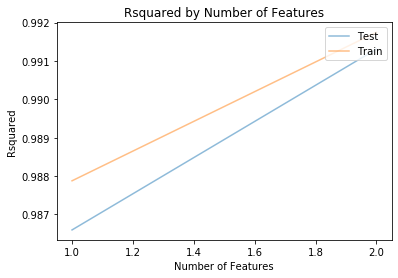

In [8]:
cutoffs = [100000000,400000, 5000, 25000,20]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = optimal_lm_model(x, y, cutoffs)

From above graphs we can see Train data is better than Test data because we did prediction only on Train data